<a href="https://colab.research.google.com/github/PhilippMatthes/diplom/blob/master/src/shl-deep-learning-autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing a 1d convolutional autoencoder

In [ ]:
# Free up some disk space on colab
!rm -rf /usr/local/lib/python2.7
!rm -rf /swift
!rm -rf /usr/local/lib/python3.6/dist-packages/torch
!rm -rf /usr/local/lib/python3.6/dist-packages/pystan
!rm -rf /usr/local/lib/python3.6/dist-packages/spacy
!rm -rf /tensorflow-1.15.2/

In [ ]:
# Get needed auxiliary files for colab
!git clone https://github.com/philippmatthes/diplom

Cloning into 'diplom'...
remote: Enumerating objects: 1609, done.
remote: Counting objects: 100% (946/946), done.
remote: Compressing objects: 100% (632/632), done.
remote: Total 1609 (delta 456), reused 739 (delta 274), pack-reused 663
Receiving objects: 100% (1609/1609), 34.21 MiB | 25.64 MiB/s, done.
Resolving deltas: 100% (832/832), done.


In [ ]:
# Change into src dir and load our datasets
%cd /content/diplom/src
!mkdir shl-dataset

/content/diplom/src


In [ ]:
# Download training datasets
!wget -nc -O shl-dataset/challenge-2019-train_torso.zip http://www.shl-dataset.org/wp-content/uploads/SHLChallenge2019/challenge-2019-train_torso.zip
!wget -nc -O shl-dataset/challenge-2019-train_bag.zip http://www.shl-dataset.org/wp-content/uploads/SHLChallenge2019/challenge-2019-train_bag.zip
!wget -nc -O shl-dataset/challenge-2019-train_hips.zip http://www.shl-dataset.org/wp-content/uploads/SHLChallenge2019/challenge-2019-train_hips.zip
!wget -nc -O shl-dataset/challenge-2020-train_hand.zip http://www.shl-dataset.org/wp-content/uploads/SHLChallenge2020/challenge-2020-train_hand.zip
# Download validation dataset
!wget -nc -O shl-dataset/challenge-2020-validation.zip http://www.shl-dataset.org/wp-content/uploads/SHLChallenge2020/challenge-2020-validation.zip

In [ ]:
# Unzip training datasets
!unzip -n -d shl-dataset/challenge-2019-train_torso shl-dataset/challenge-2019-train_torso.zip
!rm shl-dataset/challenge-2019-train_torso.zip
!unzip -n -d shl-dataset/challenge-2019-train_bag shl-dataset/challenge-2019-train_bag.zip
!rm shl-dataset/challenge-2019-train_bag.zip
!unzip -n -d shl-dataset/challenge-2019-train_hips shl-dataset/challenge-2019-train_hips.zip
!rm shl-dataset/challenge-2019-train_hips.zip
!unzip -n -d shl-dataset/challenge-2020-train_hand shl-dataset/challenge-2020-train_hand.zip
!rm shl-dataset/challenge-2020-train_hand.zip
# Unzip validation dataset
!unzip -n -d shl-dataset/challenge-2020-validation shl-dataset/challenge-2020-validation.zip
!rm shl-dataset/challenge-2020-validation.zip

In [ ]:
%cd /content/diplom/src
%tensorflow_version 2.x

/content/diplom/src


In [ ]:
# Define all datasets to train our model on

from pathlib import Path

TRAIN_DATASET_DIRS = [
    Path('shl-dataset/challenge-2019-train_torso/train/Torso'),
    Path('shl-dataset/challenge-2019-train_bag/train/Bag'),
    Path('shl-dataset/challenge-2019-train_hips/train/Hips'),
    Path('shl-dataset/challenge-2020-train_hand/train/Hand'),
]

VALIDATION_DATASET_DIRS = [
    Path('shl-dataset/challenge-2020-validation/validation/Torso'),         
    Path('shl-dataset/challenge-2020-validation/validation/Bag'),   
    Path('shl-dataset/challenge-2020-validation/validation/Hips'),   
    Path('shl-dataset/challenge-2020-validation/validation/Hand'),                  
]


In [ ]:
from tensorflow import keras

# Check that we can use our GPU, to not wait forever during training
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8577383555151566386, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16183459840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11171126248970069869
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [ ]:
# Create our model

from tensorflow.keras import layers, models


input_window = layers.Input(shape=(500,1))
x = layers.Conv1D(256, 7, activation="relu", padding="same")(input_window)
x = layers.Dropout(rate=0.2)(x)
x = layers.MaxPooling1D(2, padding="same")(x)
x = layers.Conv1D(128, 7, activation="relu", padding="same")(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.MaxPooling1D(5, padding="same")(x)
x = layers.Conv1D(1, 7, activation="relu", padding="same")(x)
encoded = layers.Dropout(rate=0.2)(x)

encoder = models.Model(input_window, encoded)

x = layers.Conv1D(1, 7, activation="relu", padding="same")(encoded)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv1DTranspose(128, 7, activation="relu", padding="same")(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.UpSampling1D(5)(x)
x = layers.Conv1DTranspose(256, 7, activation="relu", padding="same")(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.UpSampling1D(2)(x)
decoded = layers.Conv1DTranspose(1, 3, activation='sigmoid', padding='same')(x)
autoencoder = models.Model(input_window, decoded)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500, 1)]          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 500, 256)          2048      
_________________________________________________________________
dropout_6 (Dropout)          (None, 500, 256)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 250, 128)          229504    
_________________________________________________________________
dropout_7 (Dropout)          (None, 250, 128)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 128)           0   

In [ ]:
import joblib

from collections import OrderedDict

import pandas as pd
import numpy as np

from tqdm import tqdm

X_attributes = [
    'acc_y',
]

X_files = [
    'Acc_y.txt',
]

scalers = OrderedDict({})
for a in X_attributes:
    scaler = joblib.load(f'models/shl-scalers/{a}.scaler.joblib')
    scaler.copy = False # Save memory
    scalers[a] = scaler

sample_length = 500

class SHLDatasetGenerator(keras.utils.Sequence):    
    def __init__(
        self, 
        dataset_dirs, 
        batch_size=pow(2, 5),
        prefetch_size_per_dataset=pow(2, 14), 
        xdtype=np.float16
    ):
        self.dataset_dirs = dataset_dirs
        self.batch_size = batch_size
        
        self.prefetch_size_per_dataset = prefetch_size_per_dataset
        self.prefetched_X_batches = None
        self.prefetched_base_step_idx = None

        self.xdtype = xdtype

        # Count samples in datasets
        self.dataset_samples = [] # (dim datasets)
        for dataset_dir in dataset_dirs:
            # Every file in the dataset has the same length
            samples = 0
            with open(dataset_dir / X_files[0]) as f:
                for _ in tqdm(f, desc=f'Counting samples in {dataset_dir}'):
                    samples += 1
            assert samples > prefetch_size_per_dataset
            self.dataset_samples.append(samples)
        
        self._setup_new_chunked_readers()

    def __len__(self):
        # Datasets should be of equal length, but in case some dataset
        # is shorter than the others, we need to truncate our samples
        max_n_samples = min(self.dataset_samples) * len(self.dataset_dirs)
        # Datasets need to be truncated by the prefetch size
        padding = self.prefetch_size_per_dataset * len(self.dataset_dirs)
        max_n_samples = max_n_samples - (max_n_samples % padding)
        return int(np.floor(max_n_samples / self.batch_size))                  

    def _setup_new_chunked_readers(self):
        # Throw away potentially existing readers
        self.X_attr_readers_for_datasets = [] # (dim datasets x readers)

        # Initialize new chunked csv readers
        read_csv_kwargs = { 'sep': ' ', 'header': None, 'chunksize': self.prefetch_size_per_dataset }
        for dirname in self.dataset_dirs:
            X_readers = []
            for filename in X_files:
                X_reader = pd.read_csv(dirname / filename, dtype=self.xdtype, **read_csv_kwargs)
                X_readers.append(X_reader)
            self.X_attr_readers_for_datasets.append(X_readers)

    def on_epoch_end(self):
        self._setup_new_chunked_readers()

    def _prefetch_batches(self):
        X_combined = None # dim (None x sample_length x n_X_attributes)
        for X_attr_readers in self.X_attr_readers_for_datasets:
            X_subdataset = None # dim (None x sample_length x n_X_attributes)
            for X_attribute, X_attr_reader in zip(X_attributes, X_attr_readers):
                X_attr_track = next(X_attr_reader)
                X_attr_track = np.nan_to_num(X_attr_track.to_numpy())
                X_attr_track = scalers[X_attribute].transform(X_attr_track)
                X_subdataset = X_attr_track if X_subdataset is None else np.dstack((X_subdataset, X_attr_track))
            X_combined = X_subdataset if X_combined is None else np.concatenate((X_combined, X_subdataset), axis=0)
        
        # Shuffle data points
        p = np.random.permutation(len(X_combined))
        X_combined = X_combined[p]

        # Pack the prefetched data into batches
        self.prefetched_X_batches = np.split(X_combined, len(X_combined) // self.batch_size, axis=0)

    def __getitem__(self, step_idx):
        if self.prefetched_X_batches is None:
            is_prefetched = False
        else:
            n_prefetched_batches = len(self.prefetched_X_batches)
            is_above_prefetch = step_idx > (self.prefetched_base_step_idx + n_prefetched_batches - 1)
            is_below_prefetch = step_idx < self.prefetched_base_step_idx
            is_prefetched = (not is_above_prefetch) and (not is_below_prefetch)

        if not is_prefetched:
            self._prefetch_batches()
            self.prefetched_base_step_idx = step_idx

        scoped_idx = step_idx - self.prefetched_base_step_idx
        X = self.prefetched_X_batches[scoped_idx]

        return X, X

# Use batch generators to not preprocess the whole dataset at once   
train_generator = SHLDatasetGenerator(TRAIN_DATASET_DIRS, prefetch_size_per_dataset=pow(2, 16))
validation_generator = SHLDatasetGenerator(VALIDATION_DATASET_DIRS)

# Train model
callbacks = [
    keras.callbacks.CSVLogger('train.log', append=False),
    keras.callbacks.ModelCheckpoint(
        'models/shl-1d-conv-autoencoder', save_best_only=True, monitor='val_loss', verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.25, patience=2, min_lr=0.0001, verbose=1
    ),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
]

autoencoder.fit(
    train_generator,
    epochs=20,
    verbose=1,
    callbacks=callbacks,
    validation_data=validation_generator,
    shuffle=False, # Shuffling doesn't work with our prefetching
)

Counting samples in shl-dataset/challenge-2019-train_torso/train/Torso: 196072it [00:00, 307474.32it/s]
Counting samples in shl-dataset/challenge-2019-train_bag/train/Bag: 196072it [00:00, 315492.66it/s]
Counting samples in shl-dataset/challenge-2019-train_hips/train/Hips: 196072it [00:00, 314898.54it/s]
Counting samples in shl-dataset/challenge-2020-train_hand/train/Hand: 196072it [00:00, 318320.54it/s]
Counting samples in shl-dataset/challenge-2020-validation/validation/Torso: 28789it [00:00, 310482.68it/s]
Counting samples in shl-dataset/challenge-2020-validation/validation/Bag: 28789it [00:00, 295352.42it/s]
Counting samples in shl-dataset/challenge-2020-validation/validation/Hips: 28789it [00:00, 299552.27it/s]
Counting samples in shl-dataset/challenge-2020-validation/validation/Hand: 28789it [00:00, 323318.65it/s]


Epoch 1/20
16384/16384 [==============================] - 252s 15ms/step - loss: 0.6025 - val_loss: 0.4589

Epoch 00001: val_loss improved from inf to 0.45893, saving model to models/shl-1d-conv-autoencoder
INFO:tensorflow:Assets written to: models/shl-1d-conv-autoencoder/assets
Epoch 2/20
16384/16384 [==============================] - 275s 15ms/step - loss: 0.5983 - val_loss: 0.4593

Epoch 00002: val_loss did not improve from 0.45893
Epoch 3/20
16384/16384 [==============================] - 272s 14ms/step - loss: 0.5978 - val_loss: 0.4831

Epoch 00003: val_loss did not improve from 0.45893

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 4/20
16384/16384 [==============================] - 270s 14ms/step - loss: 0.5970 - val_loss: 0.4644

Epoch 00004: val_loss did not improve from 0.45893
Epoch 5/20
16384/16384 [==============================] - 270s 14ms/step - loss: 0.5968 - val_loss: 0.4570

Epoch 00005: val_loss improved from 0.45893 to 0.45703

Counting samples in shl-dataset/challenge-2020-validation/validation/Torso: 28789it [00:00, 337900.67it/s]
Counting samples in shl-dataset/challenge-2020-validation/validation/Bag: 28789it [00:00, 332957.82it/s]
Counting samples in shl-dataset/challenge-2020-validation/validation/Hips: 28789it [00:00, 325484.37it/s]
Counting samples in shl-dataset/challenge-2020-validation/validation/Hand: 28789it [00:00, 320880.28it/s]


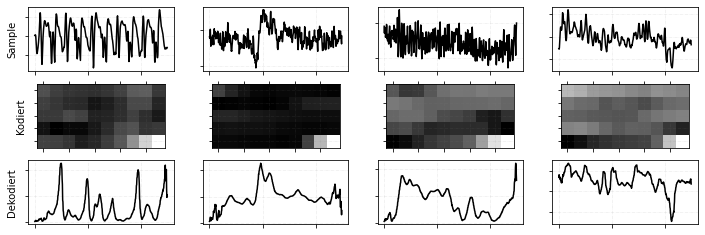

In [ ]:
import matplotlib.pyplot as plt

n_visualizations = 4
fig, axs = plt.subplots(3, n_visualizations)
fig.set_size_inches(3 * n_visualizations, 4)

vis_generator = SHLDatasetGenerator(VALIDATION_DATASET_DIRS, prefetch_size_per_dataset=pow(2, 14))
vis_samples, _ = vis_generator[0]

for ax in axs.flatten():
    ax.grid(
        b = True, 
        color ='grey',
        linestyle ='-.', 
        linewidth = 0.5,
        alpha = 0.2
    )
    ax.set_xticklabels([])
    ax.set_yticklabels([])

axs[0, 0].set_ylabel('Sample')
axs[1, 0].set_ylabel('Kodiert')
axs[2, 0].set_ylabel('Dekodiert')

for i, sample in enumerate(vis_samples[:n_visualizations]):
    encoding = encoder.predict(sample.reshape(1, 500, 1)).reshape(5, 10)
    prediction = autoencoder.predict(sample.reshape(1, 500, 1)).reshape(500, 1)
    axs[0, i].plot(sample, color='black')
    axs[1, i].matshow(encoding, cmap=plt.cm.binary)
    axs[2, i].plot(prediction, color='black')

plt.show()

In [ ]:
plt.savefig(
    f'../images/shl/autoencoder.pdf',
    dpi=1200,
    bbox_inches='tight'
)

<Figure size 432x288 with 0 Axes>